# 環境設定とインポート

In [13]:
# ========================================
# 02_simple_cnn.ipynb
# 銀河画像分類 - シンプルなCNNモデル
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from PIL import Image
import io
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 乱数シード固定（再現性のため）
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

if torch.cuda.is_available():
    print(f"GPU名: {torch.cuda.get_device_name(0)}")
    print(f"GPUメモリ: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  CPUモードで実行（学習に時間がかかります）")

print(f"\nPyTorchバージョン: {torch.__version__}")
print(f"✅ インポート完了")


使用デバイス: cuda
GPU名: NVIDIA GeForce RTX 3060
GPUメモリ: 12.88 GB

PyTorchバージョン: 2.9.1+cu130
✅ インポート完了


# データの読み込み

In [14]:
# データセットのパス
dataset_path = Path("./MultimodalUniverse/galaxy10_decals/dataset")

# 保存したdata_info.pklを読み込み
print("data_info.pkl を読み込み中...")
with open(dataset_path / "data_info.pkl", 'rb') as f:
    data_info = pickle.load(f)

# 情報を取得
class_weights = data_info['class_weights']
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
class_names = data_info['class_names']
rgb_mean = data_info['rgb_mean']
rgb_std = data_info['rgb_std']
image_size = data_info['image_size']

print("✅ data_info.pkl 読み込み完了")
print(f"  画像サイズ: {image_size}")
print(f"  クラス数: {len(class_names)}")
print(f"  RGB平均: {[f'{m:.4f}' for m in rgb_mean]}")
print(f"  RGB標準偏差: {[f'{s:.4f}' for s in rgb_std]}")

# parquetファイルを読み込み
print("\nparquetファイルを読み込み中...")
parquet_files = sorted(dataset_path.glob("*.parquet"))
dfs = [pd.read_parquet(f) for f in parquet_files]
df_all = pd.concat(dfs, ignore_index=True)

print(f"✅ データ読み込み完了")
print(f"  総サンプル数: {len(df_all):,}")
print(f"  列: {df_all.columns.tolist()}")

# クラス分布を確認
label_counts = df_all['gz10_label'].value_counts().sort_index()
print(f"\nクラス分布:")
for i, count in label_counts.items():
    print(f"  クラス {i}: {count:4d} ({count/len(df_all)*100:5.1f}%)")


data_info.pkl を読み込み中...
✅ data_info.pkl 読み込み完了
  画像サイズ: (256, 256)
  クラス数: 10
  RGB平均: ['0.1694', '0.1653', '0.1597']
  RGB標準偏差: ['0.1295', '0.1164', '0.1085']

parquetファイルを読み込み中...
✅ データ読み込み完了
  総サンプル数: 17,736
  列: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale']

クラス分布:
  クラス 0: 1081 (  6.1%)
  クラス 1: 1853 ( 10.4%)
  クラス 2: 2645 ( 14.9%)
  クラス 3: 2027 ( 11.4%)
  クラス 4:  334 (  1.9%)
  クラス 5: 2043 ( 11.5%)
  クラス 6: 1829 ( 10.3%)
  クラス 7: 2628 ( 14.8%)
  クラス 8: 1423 (  8.0%)
  クラス 9: 1873 ( 10.6%)


# Train/Val/Test分割

In [15]:
# データを分割 (70% train, 15% validation, 15% test)
print("データを分割中...")

# まず train+val と test に分割（85% / 15%）
train_val_df, test_df = train_test_split(
    df_all, 
    test_size=0.15, 
    random_state=SEED,
    stratify=df_all['gz10_label']  # クラス比率を保つ
)

# train+val を train と val に分割（約70% / 15%）
# 0.85 * 0.8235 ≈ 0.70
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,  # 15% / 85% ≈ 0.1765
    random_state=SEED,
    stratify=train_val_df['gz10_label']
)

print(f"✅ データ分割完了")
print(f"  Train: {len(train_df):5d} ({len(train_df)/len(df_all)*100:.1f}%)")
print(f"  Val:   {len(val_df):5d} ({len(val_df)/len(df_all)*100:.1f}%)")
print(f"  Test:  {len(test_df):5d} ({len(test_df)/len(df_all)*100:.1f}%)")

# 各分割のクラス分布を確認
print("\n各分割のクラス分布:")
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    counts = split_df['gz10_label'].value_counts().sort_index()
    print(f"\n{split_name}:")
    for i, count in counts.items():
        print(f"  クラス {i}: {count:3d}", end=' ')
        if i % 5 == 4:
            print()  # 5個ごとに改行

# インデックスをリセット
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("\n✅ 準備完了")


データを分割中...
✅ データ分割完了
  Train: 12414 (70.0%)
  Val:    2661 (15.0%)
  Test:   2661 (15.0%)

各分割のクラス分布:

Train:
  クラス 0: 757   クラス 1: 1297   クラス 2: 1851   クラス 3: 1419   クラス 4: 234 
  クラス 5: 1429   クラス 6: 1280   クラス 7: 1840   クラス 8: 996   クラス 9: 1311 

Val:
  クラス 0: 162   クラス 1: 278   クラス 2: 397   クラス 3: 304   クラス 4:  50 
  クラス 5: 307   クラス 6: 275   クラス 7: 394   クラス 8: 213   クラス 9: 281 

Test:
  クラス 0: 162   クラス 1: 278   クラス 2: 397   クラス 3: 304   クラス 4:  50 
  クラス 5: 307   クラス 6: 274   クラス 7: 394   クラス 8: 214   クラス 9: 281 

✅ 準備完了


# 画像読み込み関数

✅ 画像読み込み関数のテスト成功
  画像サイズ: (256, 256)
  画像モード: RGB


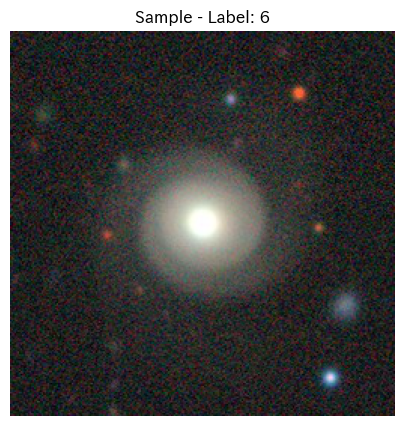

In [16]:
# 画像をPIL Imageに変換する関数
def get_image_from_row(row):
    """DataFrameの行から画像を取得"""
    image_data = row['rgb_image']
    
    # すでにPIL Imageの場合
    if isinstance(image_data, Image.Image):
        return image_data
    
    # numpy配列の場合
    if isinstance(image_data, np.ndarray):
        return Image.fromarray(image_data.astype('uint8'))
    
    # バイト列の場合
    if isinstance(image_data, bytes):
        return Image.open(io.BytesIO(image_data))
    
    # 辞書の場合
    if isinstance(image_data, dict):
        if 'bytes' in image_data:
            return Image.open(io.BytesIO(image_data['bytes']))
        elif 'path' in image_data:
            return Image.open(image_data['path'])
    
    raise ValueError(f"Unsupported image format: {type(image_data)}")

# テスト
test_img = get_image_from_row(train_df.iloc[0])
print(f"✅ 画像読み込み関数のテスト成功")
print(f"  画像サイズ: {test_img.size}")
print(f"  画像モード: {test_img.mode}")

# サンプル表示
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.title(f"Sample - Label: {train_df.iloc[0]['gz10_label']}")
plt.axis('off')
plt.show()


# PyTorch Dataset クラス

In [17]:
class GalaxyDataset(Dataset):
    """銀河画像データセット"""
    
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe: pandas DataFrame
            transform: torchvision transforms
        """
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 行を取得
        row = self.df.iloc[idx]
        
        # 画像を取得
        image = get_image_from_row(row)
        
        # ラベルを取得
        label = int(row['gz10_label'])
        
        # transformを適用
        if self.transform:
            image = self.transform(image)
        
        return image, label

# テスト用Dataset（transformなし）
test_dataset = GalaxyDataset(train_df.head(10))
test_img, test_label = test_dataset[0]

print(f"✅ Dataset クラスのテスト成功")
print(f"  データセット長: {len(test_dataset)}")
print(f"  画像型: {type(test_img)}")
print(f"  ラベル型: {type(test_label)}")
print(f"  ラベル値: {test_label}")


✅ Dataset クラスのテスト成功
  データセット長: 10
  画像型: <class 'PIL.PngImagePlugin.PngImageFile'>
  ラベル型: <class 'int'>
  ラベル値: 6


# データ拡張（Transforms）の定義

✅ Transforms 定義完了

【訓練用】データ拡張あり:
  - ランダム回転: ±180度
  - 水平反転: 50%
  - 垂直反転: 50%
  - 色調整: 明るさ・コントラスト±20%, 彩度±10%
  - 正規化: データセット統計を使用

【検証/テスト用】データ拡張なし:
  - 正規化のみ


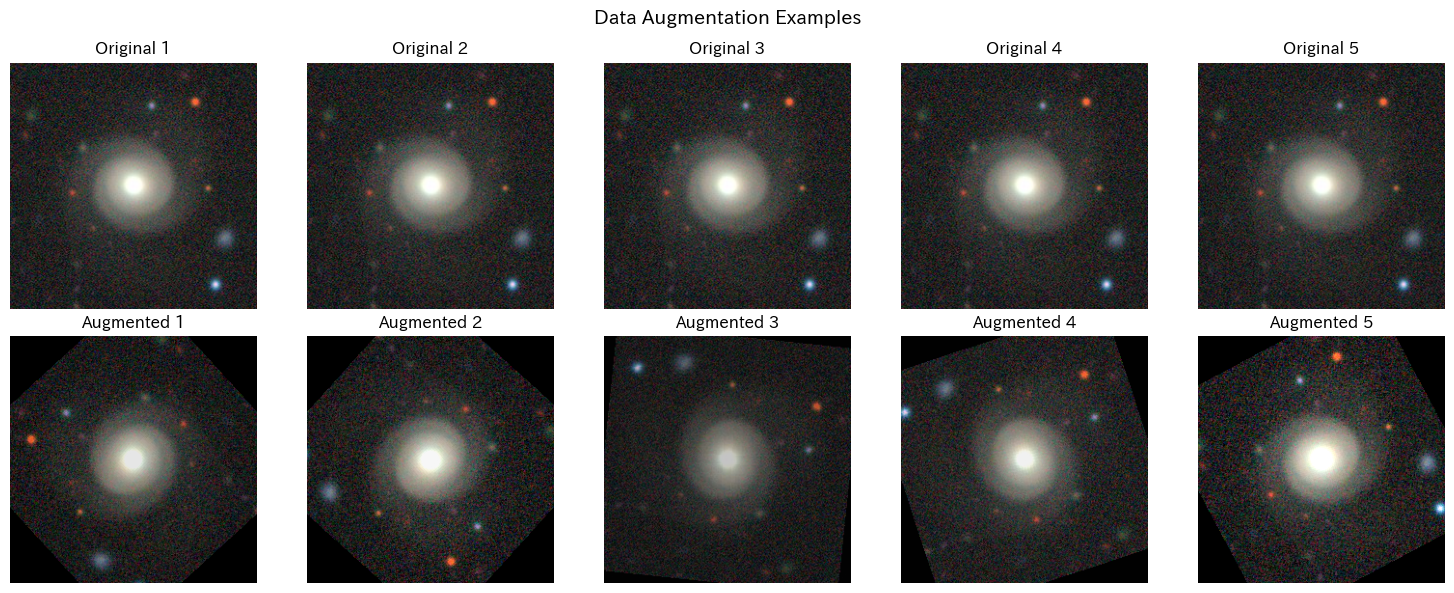


💡 データ拡張により、実質的なデータ量が増加
   → 過学習を防ぎ、汎化性能が向上


In [18]:
# データ拡張の定義

# 訓練用 transform（データ拡張あり）
train_transform = transforms.Compose([
    transforms.RandomRotation(180),           # ランダム回転（±180度）
    transforms.RandomHorizontalFlip(p=0.5),  # 水平反転（50%の確率）
    transforms.RandomVerticalFlip(p=0.5),    # 垂直反転（50%の確率）
    transforms.ColorJitter(                   # 色調整
        brightness=0.2,                       # 明るさ ±20%
        contrast=0.2,                         # コントラスト ±20%
        saturation=0.1,                       # 彩度 ±10%
    ),
    transforms.ToTensor(),                    # PIL → Tensor (0-1に正規化)
    transforms.Normalize(                     # 標準化
        mean=rgb_mean,                        # データセットの実際の平均
        std=rgb_std                           # データセットの実際の標準偏差
    )
])

# 検証/テスト用 transform（データ拡張なし）
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=rgb_mean, std=rgb_std)
])

print("✅ Transforms 定義完了")
print("\n【訓練用】データ拡張あり:")
print("  - ランダム回転: ±180度")
print("  - 水平反転: 50%")
print("  - 垂直反転: 50%")
print("  - 色調整: 明るさ・コントラスト±20%, 彩度±10%")
print("  - 正規化: データセット統計を使用")

print("\n【検証/テスト用】データ拡張なし:")
print("  - 正規化のみ")

# transformの効果を可視化
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# オリジナル画像
original_img = get_image_from_row(train_df.iloc[0])

for i in range(5):
    # オリジナル
    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # 拡張後
    # ToTensor後はCHW形式なので、HWCに変換して表示
    augmented = train_transform(original_img)
    # 標準化を逆変換して表示用に
    augmented_display = augmented.clone()
    for c in range(3):
        augmented_display[c] = augmented_display[c] * rgb_std[c] + rgb_mean[c]
    augmented_display = augmented_display.permute(1, 2, 0).numpy()
    augmented_display = np.clip(augmented_display, 0, 1)
    
    axes[1, i].imshow(augmented_display)
    axes[1, i].set_title(f'Augmented {i+1}')
    axes[1, i].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=14)
plt.tight_layout()
plt.show()

print("\n💡 データ拡張により、実質的なデータ量が増加")
print("   → 過学習を防ぎ、汎化性能が向上")


# DataLoader の作成

バッチサイズ: 32
ワーカー数: 2

✅ Dataset 作成完了
  Train: 12,414 samples
  Val:   2,661 samples
  Test:  2,661 samples

✅ DataLoader 作成完了
  Train batches: 388
  Val batches:   84
  Test batches:  84

【バッチの確認】
  images shape: torch.Size([32, 3, 256, 256])
  labels shape: torch.Size([32])
  images dtype: torch.float32
  labels dtype: torch.int64
  images range: [-1.472, 7.744]


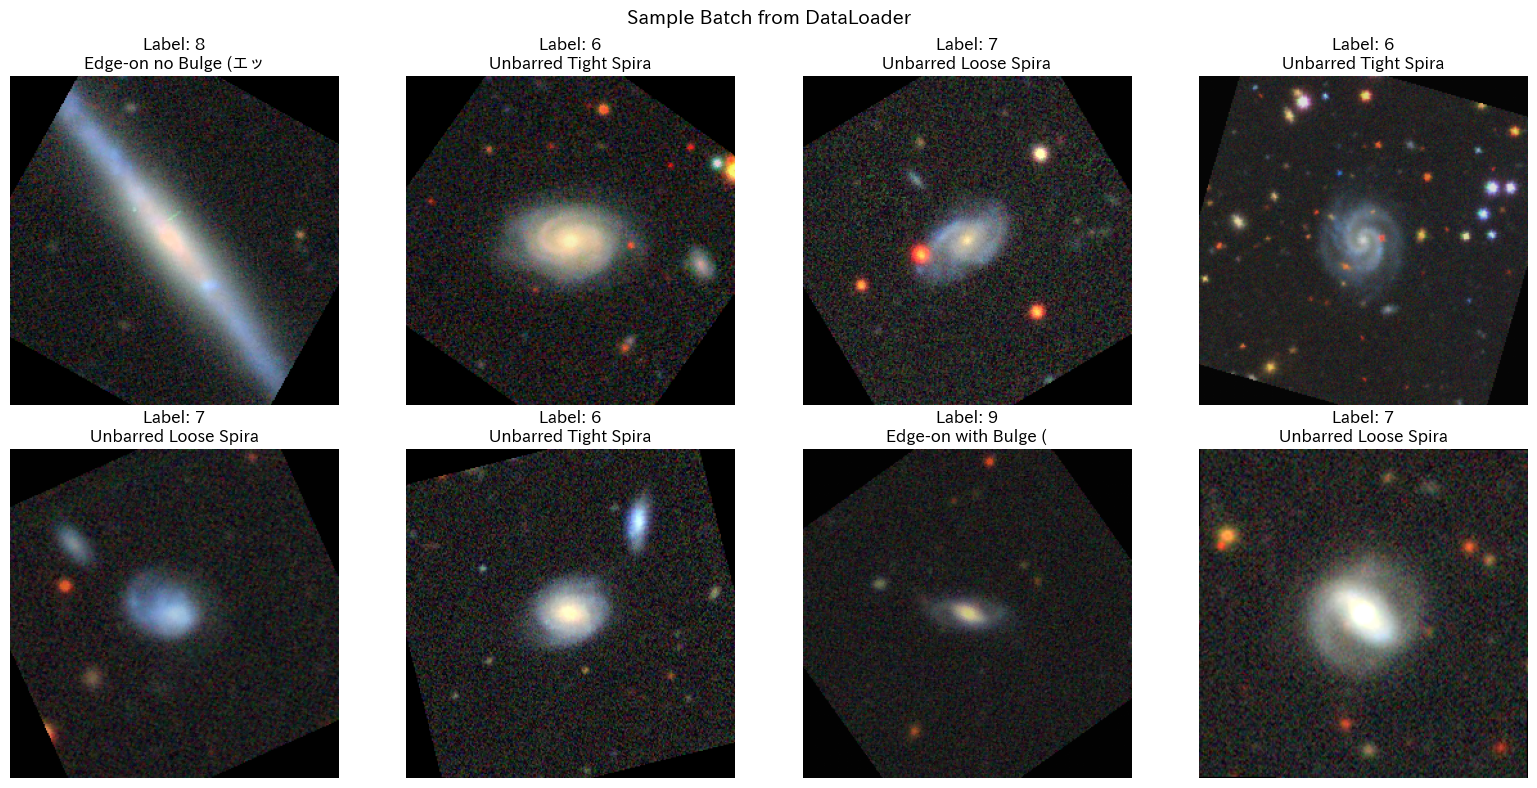


✅ DataLoaderのテスト完了


In [19]:
# ハイパーパラメータ
BATCH_SIZE = 32  # RTX 3060なら32-64が適切
NUM_WORKERS = 2  # データ読み込みの並列数

print(f"バッチサイズ: {BATCH_SIZE}")
print(f"ワーカー数: {NUM_WORKERS}")

# Datasetの作成
train_dataset = GalaxyDataset(train_df, transform=train_transform)
val_dataset = GalaxyDataset(val_df, transform=eval_transform)
test_dataset = GalaxyDataset(test_df, transform=eval_transform)

print(f"\n✅ Dataset 作成完了")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val:   {len(val_dataset):,} samples")
print(f"  Test:  {len(test_dataset):,} samples")

# DataLoaderの作成
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # 訓練時はシャッフル
    num_workers=NUM_WORKERS,
    pin_memory=True        # GPU使用時は高速化
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # 検証時はシャッフル不要
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\n✅ DataLoader 作成完了")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# DataLoaderのテスト
images, labels = next(iter(train_loader))
print(f"\n【バッチの確認】")
print(f"  images shape: {images.shape}")  # [batch_size, 3, 256, 256]
print(f"  labels shape: {labels.shape}")  # [batch_size]
print(f"  images dtype: {images.dtype}")
print(f"  labels dtype: {labels.dtype}")
print(f"  images range: [{images.min():.3f}, {images.max():.3f}]")

FONT_NAME = "IPAexGothic"
plt.rcParams['font.family'] = FONT_NAME
plt.rcParams['font.sans-serif'] = [FONT_NAME]
plt.rcParams['axes.unicode_minus'] = False

# バッチから数枚表示
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    img = images[i]
    label = labels[i].item()
    
    # 正規化を逆変換
    img_display = img.clone()
    for c in range(3):
        img_display[c] = img_display[c] * rgb_std[c] + rgb_mean[c]
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)
    
    axes[i].imshow(img_display)
    axes[i].set_title(f'Label: {label}\n{class_names[label][:20]}')
    axes[i].axis('off')

plt.suptitle('Sample Batch from DataLoader', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✅ DataLoaderのテスト完了")


# シンプルなCNNモデルの定義

In [20]:
class SimpleCNN(nn.Module):
    """シンプルな3層CNNモデル"""
    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # 畳み込み層1: 3 → 32チャンネル
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 256→128
        
        # 畳み込み層2: 32 → 64チャンネル
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 128→64
        
        # 畳み込み層3: 64 → 128チャンネル
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 64→32
        
        # 全結合層
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Conv Block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Conv Block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Conv Block 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# モデルのインスタンス化
model = SimpleCNN(num_classes=10).to(device)

print("✅ モデル定義完了")
print(f"\nモデル構造:")
print(model)

# パラメータ数の計算
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n総パラメータ数: {total_params:,}")
print(f"学習可能パラメータ数: {trainable_params:,}")

# テスト: ダミー入力で動作確認
dummy_input = torch.randn(1, 3, 256, 256).to(device)
dummy_output = model(dummy_input)
print(f"\nテスト実行:")
print(f"  入力shape: {dummy_input.shape}")
print(f"  出力shape: {dummy_output.shape}")
print(f"✅ モデルは正常に動作します")


✅ モデル定義完了

モデル構造:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

総パラメータ数: 67,208,202
学習可能パラメータ数: 67,208,202

# 学習準備（Optimizer, Scheduler, Criterion）

In [21]:
# ハイパーパラメータ
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
PATIENCE = 5  # Early Stopping用

print("=" * 60)
print("学習設定")
print("=" * 60)
print(f"学習率: {LEARNING_RATE}")
print(f"エポック数: {NUM_EPOCHS}")
print(f"Early Stopping patience: {PATIENCE}")
print(f"バッチサイズ: {BATCH_SIZE}")
print(f"デバイス: {device}")

# 損失関数（クラスウェイト適用）
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"\n損失関数: CrossEntropyLoss (クラスウェイト適用)")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Optimizer: Adam (lr={LEARNING_RATE})")

# Learning Rate Scheduler（オプション）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,      # 学習率を半分に
    patience=3,      # 3エポック改善しなければ減衰
)
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

# 学習履歴を記録する辞書
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print("\n✅ 学習準備完了")
print("=" * 60)


学習設定
学習率: 0.001
エポック数: 2
Early Stopping patience: 5
バッチサイズ: 32
デバイス: cuda

損失関数: CrossEntropyLoss (クラスウェイト適用)
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

✅ 学習準備完了


# 学習関数（Train）

In [22]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """1エポック分の学習"""
    model.train()  # 学習モード
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # プログレスバー
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for images, labels in pbar:
        # デバイスに転送
        images = images.to(device)
        labels = labels.to(device)
        
        # 勾配をゼロに
        optimizer.zero_grad()
        
        # 順伝播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 逆伝播
        loss.backward()
        optimizer.step()
        
        # 統計
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # プログレスバー更新
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ 学習関数定義完了")


✅ 学習関数定義完了


# 検証関数（Validation）

In [23]:
def validate(model, val_loader, criterion, device):
    """検証"""
    model.eval()  # 評価モード
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 勾配計算不要
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # 順伝播のみ
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 統計
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # プログレスバー更新
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ 検証関数定義完了")


✅ 検証関数定義完了


# 学習メインループ（実行）

In [24]:
import time

print("=" * 70)
print("🚀 学習開始")
print("=" * 70)

# ベストモデル保存用
best_val_acc = 0.0
best_epoch = 0
patience_counter = 0

# 学習時間計測
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # 学習
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # 検証
    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )
    
    # 履歴に記録
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # 学習率のスケジューリング
    scheduler.step(val_loss)
    
    # 経過時間
    epoch_time = time.time() - epoch_start
    
    # 結果表示
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f} | Time: {epoch_time:.1f}s")
    
    # ベストモデルの保存
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        
        # モデルを保存
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, './MultimodalUniverse/galaxy10_decals/dataset/best_model.pth')
        
        print(f"✅ Best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{PATIENCE}")
    
    # Early Stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        print(f"Best Val Acc: {best_val_acc:.2f}% at epoch {best_epoch}")
        break

# 総学習時間
total_time = time.time() - start_time
print("\n" + "=" * 70)
print("✅ 学習完了")
print("=" * 70)
print(f"総学習時間: {total_time/60:.1f}分")
print(f"Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"モデル保存先: ./MultimodalUniverse/galaxy10_decals/dataset/best_model.pth")
print("=" * 70)


🚀 学習開始

Epoch 1/2
----------------------------------------------------------------------


Training:   0%|          | 0/388 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 4.6003 | Train Acc: 12.48%
Val Loss:   2.3057 | Val Acc:   15.14%
LR: 0.001000 | Time: 38.8s
✅ Best model saved! (Val Acc: 15.14%)

Epoch 2/2
----------------------------------------------------------------------


Training:   0%|          | 0/388 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 2.3103 | Train Acc: 14.10%
Val Loss:   2.3062 | Val Acc:   10.48%
LR: 0.001000 | Time: 37.3s
⏳ Patience: 1/5

✅ 学習完了
総学習時間: 1.3分
Best Val Acc: 15.14% (Epoch 1)
モデル保存先: ./MultimodalUniverse/galaxy10_decals/dataset/best_model.pth


# 学習曲線の可視化と最終評価

📊 学習結果の可視化


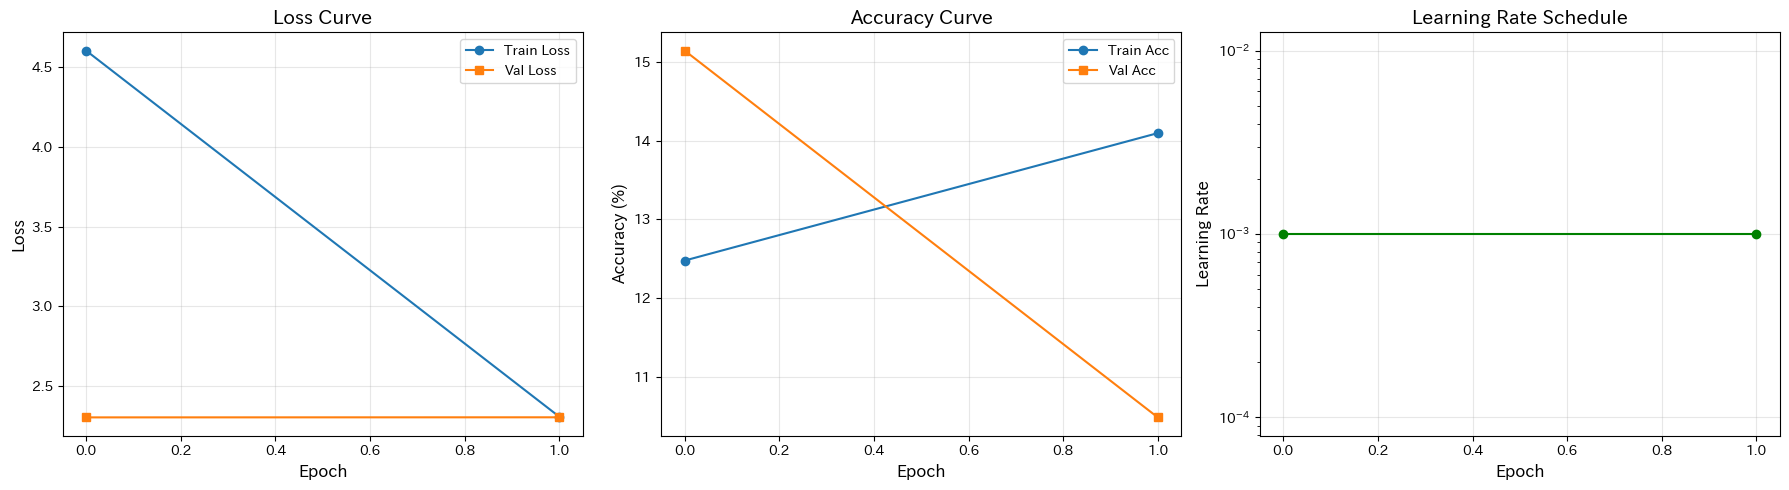


📈 学習結果の分析:
----------------------------------------------------------------------
最終 Train Accuracy: 14.10%
最終 Val Accuracy:   10.48%
差分 (Train - Val):  3.61%

✅ 良好な学習（過学習なし）

🏆 ベストモデルでテストセット評価
✅ Epoch 1 のモデルをロード
   Val Acc: 15.14%


Validation:   0%|          | 0/84 [00:00<?, ?it/s]


📊 Test Set Performance:
   Test Loss: 2.3168
   Test Acc:  15.33%

📊 Confusion Matrix


Predicting:   0%|          | 0/84 [00:00<?, ?it/s]

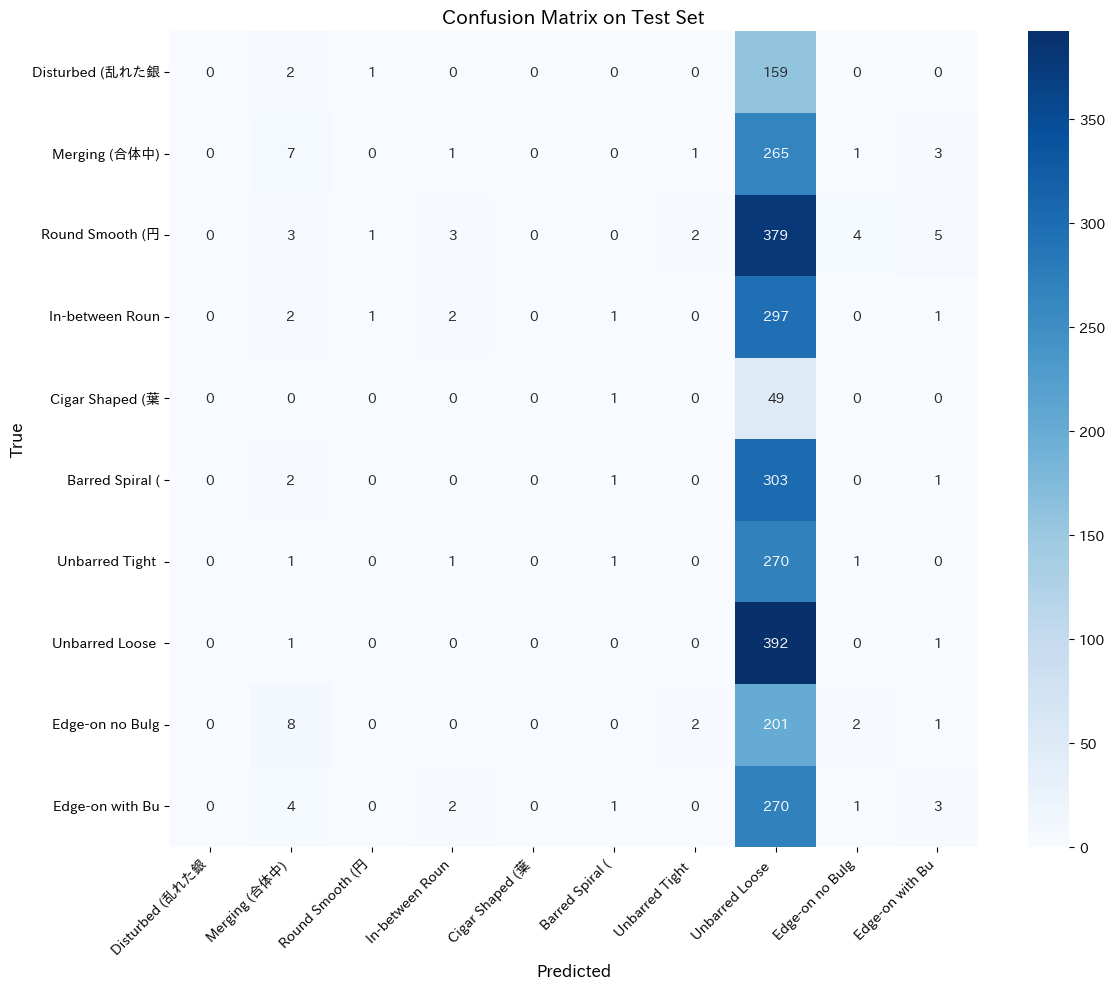


📊 クラス別の精度:
----------------------------------------------------------------------
Class 0 (Disturbed (乱れた銀河)   ):   0.0%
Class 1 (Merging (合体中)       ):   2.5%
Class 2 (Round Smooth (円形滑らか)):   0.3%
Class 3 (In-between Round (中間):   0.7%
Class 4 (Cigar Shaped (葉巻型)  ):   0.0%
Class 5 (Barred Spiral (棒渦巻) ):   0.3%
Class 6 (Unbarred Tight Spira):   0.0%
Class 7 (Unbarred Loose Spira):  99.5%
Class 8 (Edge-on no Bulge (エッ):   0.9%
Class 9 (Edge-on with Bulge ():   1.1%

📊 Classification Report
                                  precision    recall  f1-score   support

               Disturbed (乱れた銀河)      0.000     0.000     0.000       162
                   Merging (合体中)      0.233     0.025     0.045       278
            Round Smooth (円形滑らか)      0.333     0.003     0.005       397
         In-between Round (中間円形)      0.222     0.007     0.013       304
              Cigar Shaped (葉巻型)      0.000     0.000     0.000        50
             Barred Spiral (棒渦巻)      0.200     0.003    

In [25]:
print("=" * 70)
print("📊 学習結果の可視化")
print("=" * 70)

# 学習曲線のプロット
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss曲線
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Curve', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy曲線
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Curve', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], marker='o', color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14)
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 過学習の分析
print("\n📈 学習結果の分析:")
print("-" * 70)
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
gap = final_train_acc - final_val_acc

print(f"最終 Train Accuracy: {final_train_acc:.2f}%")
print(f"最終 Val Accuracy:   {final_val_acc:.2f}%")
print(f"差分 (Train - Val):  {gap:.2f}%")

if gap > 10:
    print("\n⚠️  過学習の兆候あり（Train-Valの差が10%以上）")
    print("   対策: Dropout増加、データ拡張強化、モデルを小さく")
elif gap < 5:
    print("\n✅ 良好な学習（過学習なし）")
else:
    print("\n✓  適度な学習（許容範囲）")

# ベストモデルをロード
print("\n" + "=" * 70)
print("🏆 ベストモデルでテストセット評価")
print("=" * 70)

checkpoint = torch.load('./MultimodalUniverse/galaxy10_decals/dataset/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Epoch {checkpoint['epoch']+1} のモデルをロード")
print(f"   Val Acc: {checkpoint['val_acc']:.2f}%")

# テストセットで評価
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\n📊 Test Set Performance:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Acc:  {test_acc:.2f}%")

# Confusion Matrix
print("\n" + "=" * 70)
print("📊 Confusion Matrix")
print("=" * 70)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Predicting'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix作成
cm = confusion_matrix(all_labels, all_preds)

# プロット
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[class_names[i][:15] for i in range(10)],
            yticklabels=[class_names[i][:15] for i in range(10)])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix on Test Set', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# クラス別の精度
print("\n📊 クラス別の精度:")
print("-" * 70)
for i in range(10):
    class_acc = 100 * cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"Class {i} ({class_names[i][:20]:20s}): {class_acc:5.1f}%")

# 分類レポート
print("\n" + "=" * 70)
print("📊 Classification Report")
print("=" * 70)
print(classification_report(all_labels, all_preds, 
                          target_names=[class_names[i] for i in range(10)],
                          digits=3))

print("\n" + "=" * 70)
print("✅ 全ての評価が完了しました！")
print("=" * 70)
